# To download tweets using twitter APi

In [20]:
"""import tweepy
import csv #Import csv
auth = tweepy.auth.OAuthHandler('xxxxxxxxx', 'xxxxxxxxxxxx')
auth.set_access_token('xxxxxxxxxx', 'xxxxxxxxxxxx')

api = tweepy.API(auth,wait_on_rate_limit=True)

# Open/create a file to append data to
csvFile = open('dataset.csv', 'a',encoding="utf-8",newline='')

#Use csv writer
csvWriter = csv.writer(csvFile)

for tweet in tweepy.Cursor(api.search,count=100000,
                           q = "Covid-19",re.sub('[^a-zA-Z]', '',clean )
                           tweet_mode='extended',
                           lang = "en").items():

    # Write a row to the CSV file. I use encode UTF-8
    csvWriter.writerow([tweet.full_text,tweet.user.screen_name,tweet.user.location])
    print(tweet.full_text,tweet.user.screen_name,tweet.user.location)
csvFile.close()"""

'import tweepy\nimport csv #Import csv\nauth = tweepy.auth.OAuthHandler(\'xxxxxxxxx\', \'xxxxxxxxxxxx\')\nauth.set_access_token(\'xxxxxxxxxx\', \'xxxxxxxxxxxx\')\n\napi = tweepy.API(auth,wait_on_rate_limit=True)\n\n# Open/create a file to append data to\ncsvFile = open(\'dataset.csv\', \'a\',encoding="utf-8",newline=\'\')\n\n#Use csv writer\ncsvWriter = csv.writer(csvFile)\n\nfor tweet in tweepy.Cursor(api.search,count=100000,\n                           q = "Covid-19",re.sub(\'[^a-zA-Z]\', \'\',clean )\n                           tweet_mode=\'extended\',\n                           lang = "en").items():\n\n    # Write a row to the CSV file. I use encode UTF-8\n    csvWriter.writerow([tweet.full_text,tweet.user.screen_name,tweet.user.location])\n    print(tweet.full_text,tweet.user.screen_name,tweet.user.location)\ncsvFile.close()'

# Importing dataset and Analysis

In [21]:
import pandas as pd
file_name='dataset.csv'
data = pd.read_csv(file_name, sep = ',',names = ['text','username','location'])
data.shape

(131563, 3)

In [22]:
data.head()

,text,username,location
0,RT @tsum_africa: In response to the current #C...,PaulABarter,Singapore
1,RT @FemAdesina: No presidential broadcast on C...,Abdulazizmento2,port Harcourt
2,Covid-19 Outbreak in Nigeria Is Just One of Af...,Ricardo_Gardel,"Tinton Falls, NJ"
3,RT @ChangeOrg_India: Walking miles without foo...,ahumanenough,NaN
4,RT @GhulamABilour: I have been tested positive...,tormakhay_s,"Sexi, Peru"


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131563 entries, 0 to 131562
Data columns (total 3 columns):
text        131563 non-null object
username    131563 non-null object
location    92721 non-null object
dtypes: object(3)
memory usage: 3.0+ MB


In [24]:
data=data[(data['location'].notnull())]                      #dropping empty row
data = data.sample(frac=1).reset_index(drop=True)           #resetting index
data['len']=data["text"].str.len()                          #removing clipped tweets
df1= data[(data['len'] <=137)]
df2=data[(data['len'] >=150)]
data=pd.concat([df1,df2])                              
data = data.sample(frac=1).reset_index(drop=True)       #resetting index      

In [25]:
data.shape

(35482, 4)

In [26]:
data.head()

,text,username,location,len
0,This is commendable gesture from MOJEC COVID-1...,_taraah,Eko Ile,275
1,RT @DilanTheVillain: i can hear the DJs now “i...,C3DTB,"Salt Lake City, UT",93
2,It’s the start of #MentalHealthAwarenessWeek ...,RapidTransition,Around the world,230
3,"Impact of COVID-19 on Beach Towels Market, Inf...",eprnetwork,US,99
4,RT @DilanTheVillain: i can hear the DJs now “i...,rebeccapickrum1,United States,93


# Cleaning data set by removing RT ,Links and @username

In [27]:
import numpy as np
import re
def remove_pattern(input_txt, pattern):                                           #function to remove pattern 
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt
def clean_tweets(lst):
    lst = np.vectorize(remove_pattern)(lst, "\r")                                  
    lst = np.vectorize(remove_pattern)(lst, "\n")
    lst = np.vectorize(remove_pattern)(lst, "RT @[\w]*:")                         # removing RT @x from tweets:
    lst = np.vectorize(remove_pattern)(lst, "@[\w]*")                             # removing  @xxx from tweets 
    lst = np.vectorize(remove_pattern)(lst, "https?://[A-Za-z0-9./]*")            # reremoving URL links http://xxx
    return lst

In [28]:
data['clean']= clean_tweets(data['text'])   #Cleaned Tweets are kept in separate coloumn

In [29]:
data.head()

,text,username,location,len,clean
0,This is commendable gesture from MOJEC COVID-1...,_taraah,Eko Ile,275,This is commendable gesture from MOJEC COVID-1...
1,RT @DilanTheVillain: i can hear the DJs now “i...,C3DTB,"Salt Lake City, UT",93,i can hear the DJs now “if you survived COVID...
2,It’s the start of #MentalHealthAwarenessWeek ...,RapidTransition,Around the world,230,It’s the start of #MentalHealthAwarenessWeek ...
3,"Impact of COVID-19 on Beach Towels Market, Inf...",eprnetwork,US,99,"Impact of COVID-19 on Beach Towels Market, Inf..."
4,RT @DilanTheVillain: i can hear the DJs now “i...,rebeccapickrum1,United States,93,i can hear the DJs now “if you survived COVID...


# Function to label tweets based on their sentiment.

In [30]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer           #vaderSentiment is used to tag tweets as positive, negative or neutral
analyser = SentimentIntensityAnalyzer()
def sentiment_analyzer_scores(text):
    score = analyser.polarity_scores(text)
    if score['compound'] >= 0.05 :
        return 2
    elif (score['compound'] > -0.05) and (score['compound'] < 0.05) : 
        return 1 
    else :
        return 0

In [31]:
sentiments_using_vader = data.clean.apply(lambda text: sentiment_analyzer_scores(text))     #Each tweet goes throug vader function and gets labeled.
pd.DataFrame(sentiments_using_vader.value_counts())

,clean
2,15621
0,10361
1,9500


In [32]:
data['sentiment'] = sentiments_using_vader
data.head()

,text,username,location,len,clean,sentiment
0,This is commendable gesture from MOJEC COVID-1...,_taraah,Eko Ile,275,This is commendable gesture from MOJEC COVID-1...,1
1,RT @DilanTheVillain: i can hear the DJs now “i...,C3DTB,"Salt Lake City, UT",93,i can hear the DJs now “if you survived COVID...,2
2,It’s the start of #MentalHealthAwarenessWeek ...,RapidTransition,Around the world,230,It’s the start of #MentalHealthAwarenessWeek ...,2
3,"Impact of COVID-19 on Beach Towels Market, Inf...",eprnetwork,US,99,"Impact of COVID-19 on Beach Towels Market, Inf...",1
4,RT @DilanTheVillain: i can hear the DJs now “i...,rebeccapickrum1,United States,93,i can hear the DJs now “if you survived COVID...,2


In [33]:
data.describe()

,len,sentiment
count,35482.000000,35482.000000
mean,162.006961,1.148244
std,77.083169,0.842794
min,8.000000,0.000000
25%,98.000000,0.000000
50%,129.000000,1.000000
75%,233.000000,2.000000
max,832.000000,2.000000


# Removing special characters, numbers, punctuations (except for #)

In [34]:
# remove special characters, numbers, punctuations (except for #)
data['clean'] = data['clean'].str.replace("[^a-zA-Z# ]", "")

# Removing stopwords ,converting into lower case and applying lematization.

In [35]:
from nltk.stem import WordNetLemmatizer
wl = WordNetLemmatizer()
from nltk.corpus import stopwords
cleaned_tweets = []
for index, row in data.iterrows():            #This loop goes through every tweets and removes stopwords covnverts into lower case and applyes lematization
    words_without_stopwords = [wl.lemmatize(word.lower()) for word in row.clean.split() if not word in set(stopwords.words('english')) and '#' not in word.lower()]
    cleaned_tweets.append(' '.join(words_without_stopwords))
data['Fully_cleaned_tweets'] = cleaned_tweets
data.head(10)

,text,username,location,len,clean,sentiment,Fully_cleaned_tweets
0,This is commendable gesture from MOJEC COVID-1...,_taraah,Eko Ile,275,This is commendable gesture from MOJEC COVID F...,1,this commendable gesture mojec covid food bank...
1,RT @DilanTheVillain: i can hear the DJs now “i...,C3DTB,"Salt Lake City, UT",93,i can hear the DJs now if you survived COVID ...,2,hear dj survived covid make mfn noise
2,It’s the start of #MentalHealthAwarenessWeek ...,RapidTransition,Around the world,230,Its the start of #MentalHealthAwarenessWeek a...,2,it start theme here lovely short read people s...
3,"Impact of COVID-19 on Beach Towels Market, Inf...",eprnetwork,US,99,Impact of COVID on Beach Towels Market Infers,1,impact covid beach towel market infers
4,RT @DilanTheVillain: i can hear the DJs now “i...,rebeccapickrum1,United States,93,i can hear the DJs now if you survived COVID ...,2,hear dj survived covid make mfn noise
5,"RT @syramadad: Contact tracing, explained http...",dclan2000,Vermont,65,Contact tracing explained,1,contact tracing explained
6,@Phil_Nourse Clearly heavily bot-influenced. N...,johnandi,Cornwall.,195,Clearly heavily botinfluenced Nobody could tr...,0,clearly heavily botinfluenced nobody could tru...
7,Someone needs to appoint that Lord Sumption as...,jayThomaon,Bailiwick of Jersey,238,Someone needs to appoint that Lord Sumption as...,0,someone need appoint lord sumption prime minis...
8,RT @MollyJongFast: This is delicious https://...,SafiyahNoor1,"Columbia, Maryland",61,This is delicious,2,this delicious
9,AFP- #UN chief Antonio Guterres says the plane...,Shamshadnetwork,Afghanistan,202,AFP #UN chief Antonio Guterres says the planet...,0,afp chief antonio guterres say planet paying h...


# Bargraph of Sentiment

[Text(0, 0.5, '#Tweets'),
 Text(0.5, 0, 'Negative              Neutral               Positive'),
 Text(0.5, 1.0, 'Tweets of USA-corona')]

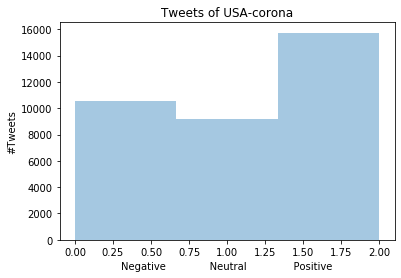

In [36]:
import seaborn as sns
sents =[]
for tw in data.Fully_cleaned_tweets:
    st = sentiment_analyzer_scores(tw)
    sents.append(st)
ax = sns.distplot(sents,kde=False,bins=3)
ax.set(xlabel='Negative              Neutral               Positive',ylabel='#Tweets',title="Tweets of USA-corona")


# Emotion of the tweets

In [39]:
from collections import Counter

def con(sentence):
    emotion_list = []
    sentence = sentence.split(' ')
    with open('emotions.txt','r') as file:
        for line in file:
            clear_line = line.replace("\n", '').replace(",",'').replace("'",'').strip()
            word, emotion = clear_line.split(':')

            if word in sentence:
                emotion_list.append(emotion)
        w = Counter(emotion_list)
        return w
    

In [40]:
data['emotion'] = data['Fully_cleaned_tweets'].apply(lambda x: con(x) )

In [41]:
data.head(10)

,text,username,location,len,clean,sentiment,Fully_cleaned_tweets,emotion
0,This is commendable gesture from MOJEC COVID-1...,_taraah,Eko Ile,275,This is commendable gesture from MOJEC COVID F...,1,this commendable gesture mojec covid food bank...,{}
1,RT @DilanTheVillain: i can hear the DJs now “i...,C3DTB,"Salt Lake City, UT",93,i can hear the DJs now if you survived COVID ...,2,hear dj survived covid make mfn noise,{}
2,It’s the start of #MentalHealthAwarenessWeek ...,RapidTransition,Around the world,230,Its the start of #MentalHealthAwarenessWeek a...,2,it start theme here lovely short read people s...,{}
3,"Impact of COVID-19 on Beach Towels Market, Inf...",eprnetwork,US,99,Impact of COVID on Beach Towels Market Infers,1,impact covid beach towel market infers,{}
4,RT @DilanTheVillain: i can hear the DJs now “i...,rebeccapickrum1,United States,93,i can hear the DJs now if you survived COVID ...,2,hear dj survived covid make mfn noise,{}
5,"RT @syramadad: Contact tracing, explained http...",dclan2000,Vermont,65,Contact tracing explained,1,contact tracing explained,{}
6,@Phil_Nourse Clearly heavily bot-influenced. N...,johnandi,Cornwall.,195,Clearly heavily botinfluenced Nobody could tr...,0,clearly heavily botinfluenced nobody could tru...,{' angry': 1}
7,Someone needs to appoint that Lord Sumption as...,jayThomaon,Bailiwick of Jersey,238,Someone needs to appoint that Lord Sumption as...,0,someone need appoint lord sumption prime minis...,{}
8,RT @MollyJongFast: This is delicious https://...,SafiyahNoor1,"Columbia, Maryland",61,This is delicious,2,this delicious,{}
9,AFP- #UN chief Antonio Guterres says the plane...,Shamshadnetwork,Afghanistan,202,AFP #UN chief Antonio Guterres says the planet...,0,afp chief antonio guterres say planet paying h...,{}


In [42]:
emo=con(data['Fully_cleaned_tweets'].sum())

In [43]:
data['text'][8]

'RT @MollyJongFast: This is delicious  https://t.co/6JxWH7xkDE'

# Plotting emotion bar graph

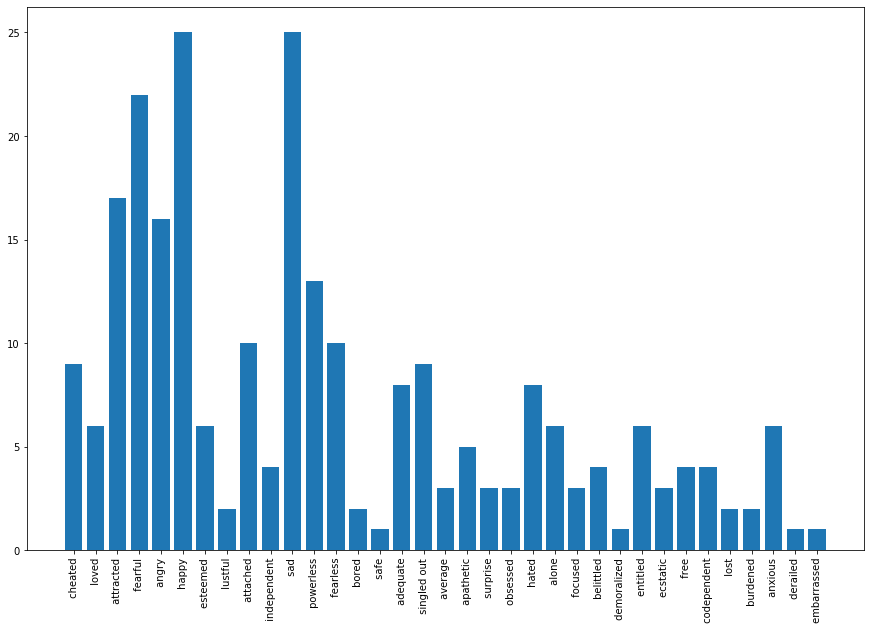

In [44]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15,10))
plt.bar(emo.keys(),emo.values())
plt.xticks(rotation = 90)
plt.show()

# Wordcloud

In [45]:
from PIL import Image
from wordcloud import WordCloud,ImageColorGenerator
import urllib
import requests
import matplotlib.pyplot as plt
def generate_wordcloud(all_words):
    Mask = np.array(Image.open(requests.get('http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png', stream=True).raw))
    image_colors = ImageColorGenerator(Mask)
    wc = WordCloud(background_color='black', height=750, width=2000,mask=Mask).generate(all_words)
    plt.figure(figsize=(10,20))
    plt.imshow(wc.recolor(color_func=image_colors),interpolation="hamming")
    plt.axis('off')
    plt.show()

# Wordcloud for Positive Sentiment

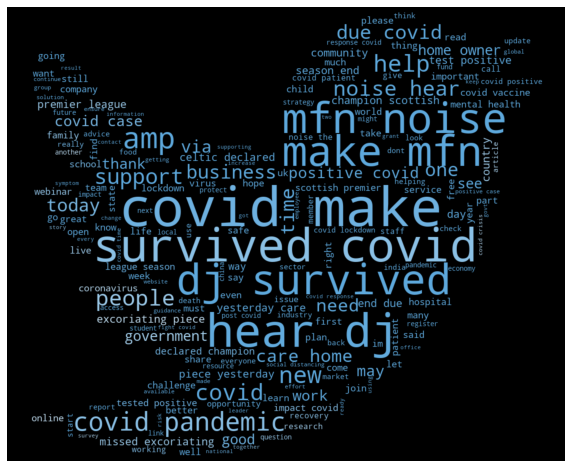

In [46]:
all_words = ' '.join([text for text in data['Fully_cleaned_tweets'][data.sentiment == 2]])
generate_wordcloud(all_words)

# Wordcloud for Neutral Sentiment

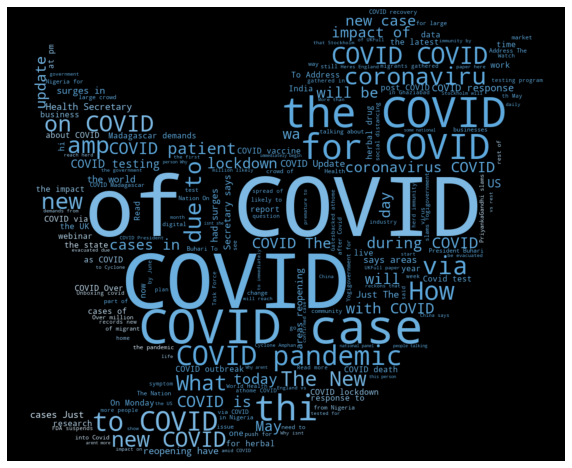

In [47]:
all_words = ' '.join([text for text in data['clean'][data.sentiment == 1]])
generate_wordcloud(all_words)

# Wordcloud for Negative Sentiment

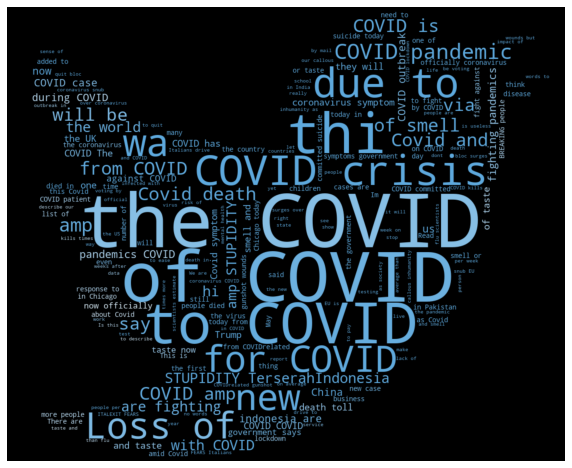

In [48]:
all_words = ' '.join([text for text in data['clean'][data.sentiment == 0]])
generate_wordcloud(all_words)

# Creating Hastag FreqDist

In [49]:
import nltk
                                                  #function to collect hashtags
def hashtag_extract(text_list):
    hashtags = []
    # Loop over the words in the tweet
    for text in text_list:
        ht = re.findall(r"#(\w+)", text)
        hashtags.append(ht)

    return hashtags

def generate_hashtag_freqdist(hashtags):
    a = nltk.FreqDist(hashtags)
    d = pd.DataFrame({'Hashtag': list(a.keys()),
                      'Count': list(a.values())})
    # selecting top 15 most frequent hashtags     
    d = d.nlargest(columns="Count", n = 25)
    plt.figure(figsize=(16,7))
    ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
    plt.xticks(rotation=80)
    ax.set(ylabel = 'Count')
    plt.show()

In [50]:
hashtags = hashtag_extract(data['clean'])
hashtags = sum(hashtags, [])

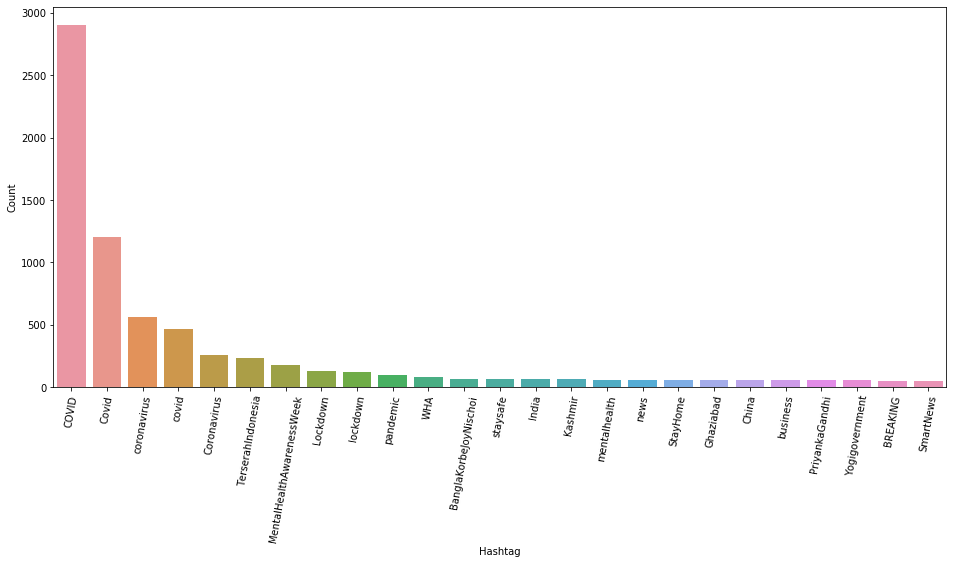

In [51]:
generate_hashtag_freqdist(hashtags)

# Tweets location bargraph

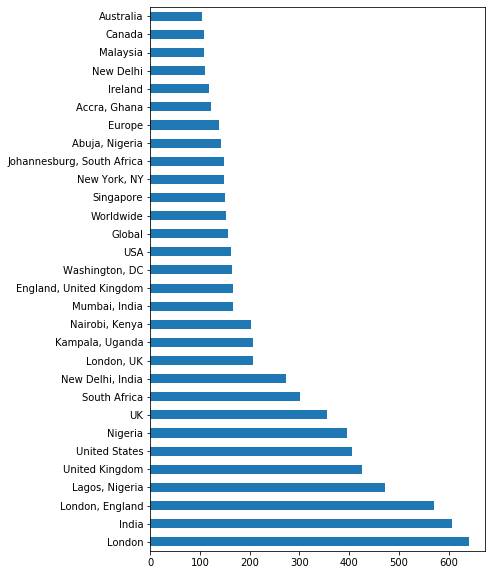

In [52]:
data['location'].value_counts().head(30).plot(kind='barh', figsize=(6,10))

# Extracting X and y from dataset

In [53]:
x = data.iloc[:,-2].values
y = data.iloc[:,-3].values

# Creating tfid vectorizer model

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_word_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english')
x = tfidf_word_vectorizer.fit_transform(x)

# Creating training and test data from the featureset and output label.

In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

#  Create and training a Machine Learning model.

In [56]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

# Validate the model created.

In [57]:
predictions = classifier.predict(X_test.toarray())

# Predicting sentiment of manual input

In [58]:
file_name='TestTweet.csv'
test=pd.read_csv(file_name)  

In [59]:
test['clean']=clean_tweets(test['text']) 
test['clean']=test['clean'].str.replace("[^a-zA-Z ]", " ")

In [60]:
for i,tweet in enumerate(test['clean']):
    op=classifier.predict(tfidf_word_vectorizer.transform([tweet]).toarray())
    if op == [0]:
        print(i,")"," ' ",test.text[i]," ' ",'\n','=','NEGATIVE','\n')
    if op == [1]:
        print(i,")"," ' ",test.text[i]," ' ",'\n','=','NEUTRAL','\n')
    if op == [2]:
        print(i,")"," ' ",test.text[i]," ' ",'\n','=','POSITIVE','\n')

0 )  '  RT @djnicholl: Show us proof that Johnson is following science, MPs urge 

https://t.co/aN9ofVaQBV  '  
 = NEUTRAL 

1 )  '  Why people think 5G responsible for coronavirus https://t.co/jloVJuO0G0 via @YouTube  '  
 = NEUTRAL 

2 )  '  Yesterday I was walking along a pier of the #Amsterdam Oude Houthaven when an angry houseboat resident invited me leave as "they don't like walkers due to the #coronavirus" WTF...  '  
 = POSITIVE 

3 )  '  RT @WyeLea: The coronavirus crisis must not be allowed to delay Brexit https://t.co/4n6mip2MVg  '  
 = NEGATIVE 

4 )  '  #N4P #C4XD #IQAI 
Coronavirus: Moderna’s US vaccine first trials show immune response https://t.co/2vy25EMqEY  '  
 = POSITIVE 

5 )  '  @HeshmatAlavi China knew what they were doing as soon as President Trump signed those papers. China will fulfill their deal as long as no pandemic happens. TWO days later &amp; here is Coronavirus knocking at our doors! Sue them, I say.  '  
 = NEGATIVE 

6 )  '  RT @jonworth: Even by Brex

47 )  '  The latest on the coronavirus outbreak with Bobby @bobbyisawake &amp; Stacy @Livviesmomma -
✅DeWine: Bar owners could lose their liquor licenses if they don’t control their customers
✅Experimental vaccine shows encouraging results
✅Trump taking hydroxychloroquine https://t.co/rAhIv5Wmki  '  
 = NEGATIVE 

48 )  '  RT @RealJamesWoods: And if not, CNN will do everything it can to get us there...  https://t.co/tXG0u7XFKO  '  
 = NEUTRAL 

49 )  '  @WyeLea Agreed 100% Let's face it, we are already in a situation of a severe downturn due to the Coronavirus. The remainer argument about supply chains won't matter as we are already badly affected (for now). So we may as leave as things cannot get any worse, only much better.  '  
 = POSITIVE 

50 )  '  RT @EaterSouls: 72 people test positive for coronavirus after mass lockdown protest in Wisconsin https://t.co/CDzqAt6aAw  '  
 = POSITIVE 

51 )  '  Joining @SeneddCWLC is Nick Capaldi, Chief Executive @Arts_Wales_. Giving evidence on b

93 )  '  Why people think #5G responsible for #coronavirus https://t.co/jloVJuO0G0 via @YouTube  '  
 = NEUTRAL 

94 )  '  RT @voiceoftheEast: Five Fresh Cases Of Coronavirus Confirmed In Abia State https://t.co/U6DS4gubmw https://t.co/YWEPJkpZZZ  '  
 = NEUTRAL 

95 )  '  NEW: The Government issues an updated response to a Parliamentary petition to say they “cannot safely include” a BSL interpreter in the room for their daily coronavirus briefings “without potentially putting them and others at risk”. #WhereIsTheInterpreter
https://t.co/eC3zbS6vJ7  '  
 = NEGATIVE 

96 )  '  RT @nousha_mohd: Zee News: Noida's most deadly coronavirus hotspot.@ZeeNews 

#ZeeNewsSealKaro https://t.co/jzi3RbqIQy  '  
 = NEUTRAL 

97 )  '  @DrHilaryJones If people who receive the vaccine are not exposed to Coronavirus how do we know how well it works &amp; whether the vaccine makes the symptoms worse..? Thank you  '  
 = POSITIVE 

98 )  '  #Uber to cut 3,000 more jobs as #coronavirus crisis rises 

#layof

140 )  '  Trump says that he has been taking #hydroxychloroquine, an antimalarial drug the #FDA warned could cause serious heart problems for coronavirus patients. He is taking the drug as a preventive measure and continued to test negative for the #coronavirus. https://t.co/8r9m9uYYXh  '  
 = NEGATIVE 

141 )  '  Brilliant video. Happily #Finland hasn't skated across thin ice without due attention to the cracks in its #coronavirus strategy https://t.co/4D5iqZfQCZ  '  
 = NEUTRAL 

142 )  '  Wow there's a lot of rich people caring about poor people all of a sudden...

Almost as if they want us to go back to work because they're seeing their wealth dissipate. 

#lockdown2020 #coronavirus #Covid19UK  '  
 = POSITIVE 

143 )  '  Commentary: Past pandemics changed the design of cities. Six ways COVID-19 could do the same https://t.co/EdJWLMXdtB  '  
 = NEUTRAL 

144 )  '  RT @MiamiHerald: Florida’s COVID-19 website guru blasts bosses, hints at data suppression. https://t.co/16sva7VeW0  '  

187 )  '  BBC News - Coronavirus: Delirium 'may be common' in Covid seriously ill https://t.co/p5G3tEX6RA  '  
 = NEUTRAL 

188 )  '  Blanquer did not specify if the 70 cases of COVID-19 were among students or teachers.
https://t.co/0jPSR4yR9j  '  
 = NEUTRAL 

189 )  '  China’s Unrestricted Warfare Could Lead to Collapse in One Year https://t.co/9BKOrZiF8Y via @YouTube
#CCPvirus #WakeUpAmerica #ResistTyranny #StandUpToEvil #COVID19 #Coronavirus #NoWorldOrder #SpyState #ContactTracing  '  
 = NEUTRAL 

190 )  '  Phone calls offered to older adults staying home during coronavirus pandemic https://t.co/Kc6xLZaW2h  '  
 = NEUTRAL 

191 )  '  @ai6yrham forced to have implanted microchips by Bill Gates." Change the subject from coronavirus to whatever other subject and you will find people in psych wards across the USA hospitalized for saying very similar things. We call this paranoia and delusions. It is a significant mental  '  
 = POSITIVE 

192 )  '  As the first tragic images of the UK

234 )  '  @LizzieStokes1 Hi Lizzie, the latest available information is available here: https://t.co/2MF5bOjtFk. However, we do have a dedicated helpline that will be able to clear this up as the guidance may not that specific. Thanks, Anas  '  
 = POSITIVE 

235 )  '  RT @Jordan9ja: #Jib : Oh No! 3-Day-Old Baby Dies After His Mother Contracted #coronavirus Before His Birth: https://t.co/l8k6RX9dD2  '  
 = NEUTRAL 

236 )  '  UK wrong to rule out global coronavirus comparisons, experts say https://t.co/RpS5cjYAa4  '  
 = NEUTRAL 



In [61]:
tweet="@briantylercohen Hey #Insane @realDonaldTrump ! Are you crazy? ANY of them don't need to die at all."
clean=clean_tweets(tweet)
clean=str(clean)
clean=re.sub('[^a-zA-Z]', ' ',clean )
clean=[clean]
op=classifier.predict(tfidf_word_vectorizer.transform(clean).toarray())
if op == [0]:
    print(tweet,'\n','=','NEGATIVE','\n')
if op == [1]:
    print(tweet,'\n','=','NEUTRAL','\n')
if op == [2]:
    print(tweet,'\n','=','POSITIVE','\n')

@briantylercohen Hey #Insane @realDonaldTrump ! Are you crazy? ANY of them don't need to die at all. 
 = NEGATIVE 



# Evaluate the model

In [62]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print('Accuracy score : ',accuracy_score(y_test, predictions)*100,'\n')

Accuracy score :  84.2609553332394 



In [63]:
print(confusion_matrix(y_test,predictions),'\n')

[[1542  233  268]
 [  62 1700  139]
 [ 138  277 2738]] 



In [64]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.89      0.75      0.81      2043
           1       0.77      0.89      0.83      1901
           2       0.87      0.87      0.87      3153

    accuracy                           0.84      7097
   macro avg       0.84      0.84      0.84      7097
weighted avg       0.85      0.84      0.84      7097

